# 1. Data Preparation

In [1]:
import numpy as np

def generate_sequences(n=128, variable_len=False, seed=13):
    basic_corners = np.array([[-1, -1], [-1, 1], [1, 1], [1, -1]])
    np.random.seed(seed)
    bases = np.random.randint(4, size=n)
    if variable_len:
        lengths = np.random.randint(3, size=n) + 2
    else:
        lengths = [4] * n
    directions = np.random.randint(2, size=n)
    points = np.array([basic_corners[[(b + i) % 4 for i in range(4)]][slice(None, None, d*2-1)][:l] + np.random.randn(l, 2) * 0.1 for b, d, l in zip(bases, directions, lengths)])
    return points, directions

In [2]:
from torch.utils.data import DataLoader, TensorDataset
import torch

In [3]:
train_points, train_directs = generate_sequences(n=256, seed=13)
x_train = torch.as_tensor(train_points).float()
print(f"x_train shape: {x_train.shape}")  # (256, 4, 2)
t_train = torch.as_tensor(x_train[:, 2:]).float()
print(f"t_train shape: {t_train.shape}")

x_train shape: torch.Size([256, 4, 2])
t_train shape: torch.Size([256, 2, 2])


In [4]:
train_set = TensorDataset(x_train, t_train)
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)

In [5]:
test_points, test_directs = generate_sequences(n=128, seed=19)
full_test = torch.as_tensor(test_points).float()
x_test = full_test[:, :2]
t_test = full_test[:, 2:]
print(f"x_test shape: {x_test.shape}")
print(f"t_test shape: {t_test.shape}")

x_test shape: torch.Size([128, 2, 2])
t_test shape: torch.Size([128, 2, 2])


In [6]:
test_set = TensorDataset(x_test, t_test)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

# 2. Model Implement
内容大纲：
- MHA：同时支持`self-attention`和`cross-attention`
- FFN
- Encoder：`self-attention` & `FFN` (Pre-Normal)
- Decoder：`self-attention`, `cross-attention` & `FFN` (Pre-Normal)
- Embedding
- Transformer

In [7]:
from torch import nn, optim

In [8]:
input_emb = nn.Linear(2, 6)

## 2.1 Embedding

In [9]:
seq_len, model_dim = 4, 6
pos_encodings = torch.zeros(seq_len, model_dim)
pos_encodings.shape

torch.Size([4, 6])

In [10]:
pos = torch.arange(0, seq_len).unsqueeze(1)
pos.shape

torch.Size([4, 1])

In [11]:
spd = torch.arange(0, model_dim, 2).float()  # spd := angular speed
spd = 10000 ** (-1 * spd / model_dim)
spd.shape

torch.Size([3])

In [12]:
(pos * spd).shape
pos_encodings[:, 0::2] = torch.sin(pos * spd)
pos_encodings[:, 1::2] = torch.cos(pos * spd)

In [13]:
pos_encodings.shape

torch.Size([4, 6])

In [14]:
max_len = 4
d_model = 6

In [15]:
position = torch.arange(0, max_len).float().unsqueeze(1)
angular_speed = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

In [16]:
encoding = torch.zeros(max_len, d_model)
encoding[:, 0::2] = torch.sin(angular_speed * position)
encoding[:, 1::2] = torch.cos(angular_speed * position)

In [17]:
encoding.shape

torch.Size([4, 6])

In [18]:
encoding.unsqueeze(0).shape

torch.Size([1, 4, 6])

In [19]:
torch.allclose(pos_encodings, encoding, 1e-8)

True

In [20]:
class Embedding(nn.Module):
    """ Input Embedding and Positional Embedding. """
    def __init__(
            self, 
            max_seq_len: int, 
            in_dim: int, 
            emb_dim: int
        ):
        super().__init__()
        self.input_dim = in_dim
        self.emb_dim = emb_dim

        # input embedding:
        self.input_emb = nn.Linear(in_dim, emb_dim)

        # positional embedding:
        pe = torch.zeros(max_seq_len, emb_dim)
        position = torch.arange(0, max_seq_len).float().unsqueeze(1)
        angular_speed = torch.arange(0, emb_dim, 2).float()
        angular_speed = 10000 ** (-1 * angular_speed / emb_dim)
        pe[:, 0::2] = torch.sin(position * angular_speed)
        pe[:, 1::2] = torch.cos(position * angular_speed)
        self.register_buffer("pos_emb", pe.unsqueeze(0))
        
    def forward(self, x: torch.Tensor):
        _, seq_len, input_dim = x.shape
        assert input_dim == self.input_dim
        x_embed = self.input_emb(x)
        x_scaled = x_embed * (self.emb_dim ** -0.5)
        # x_pe = x_scaled + self.pos_emb.view(-1, seq_len, self.emb_dim)
        x_pe = x_scaled + self.pos_emb[:, :seq_len]
        return x_pe

In [21]:
x = x_train[0].unsqueeze(0)
emb = Embedding(
    max_seq_len=4,
    in_dim=2,
    emb_dim=6
)
print(x.shape)
x_embed = emb(x)
x_embed.shape

torch.Size([1, 4, 2])


torch.Size([1, 4, 6])

## 2.2 Multi-Head Attention

In [22]:
class MHA(nn.Module):
    """ Multi-Head Attention, 
        include self-attention and cross-attention.
    """
    def __init__(
        self,
        emb_dim: int,
        n_heads: int,
        max_seq_len: int,
        dropout_rate: float = 0.1
    ):
        super().__init__()

        assert emb_dim % n_heads == 0, (
            f"emb_dim({emb_dim}) must be divisible by n_heads({n_heads})"
        )

        self.emb_dim = emb_dim
        self.n_heads = n_heads
        self.head_dim = emb_dim // n_heads
        self.max_seq_len = max_seq_len
        self.dropout_rate = dropout_rate

        self.wq = nn.Linear(self.emb_dim, self.emb_dim)
        self.wk = nn.Linear(self.emb_dim, self.emb_dim)
        self.wv = nn.Linear(self.emb_dim, self.emb_dim)
        self.register_buffer("mask", torch.tril(torch.ones(max_seq_len, max_seq_len)))
        self.dropout = nn.Dropout(self.dropout_rate)
        self.proj = nn.Linear(self.emb_dim, self.emb_dim)  # TODO: why?

        self.k = None
        self.v = None
        
    def init_kv(self, hidden_states: torch.Tensor):
        """ If this class is using in Decoder,
            this function is used to receive hidden state from Encoder. 
        """
        self.k = self.wk(hidden_states)
        self.v = self.wv(hidden_states)
        
    def clear_kv(self):
        self.k = None
        self.v = None
        
    def forward(self, x: torch.Tensor, is_masked: bool = False):
        n_batch, seq_len, _ = x.shape
        q = self.wq(x)
        if self.k is not None and self.v is not None:
            k, v = self.k, self.v
        else:
            k = self.wk(x)
            v = self.wv(x)

        # q, k, v shape: (n_batch, n_heads, seq_len, head_dim)
        # but q's seq_len may be not equal to kv's seq_len
        q = q.view(n_batch, seq_len, self.n_heads, self.head_dim).transpose(1, 2).contiguous()
        k = k.view(n_batch, -1, self.n_heads, self.head_dim).transpose(1, 2).contiguous()
        v = v.view(n_batch, -1, self.n_heads, self.head_dim).transpose(1, 2).contiguous()

        # compute attention scores:
        a = q @ k.transpose(-2, -1)  # (n_batch, n_heads, q_seq_len, kv_seq_len)
        a = a * (self.head_dim ** -0.5)
        if is_masked:  # self-masked-attention
            mask = self.mask[:seq_len, :seq_len]
            a.masked_fill_(mask == 0, -torch.inf)
        a = torch.softmax(a, dim=-1)
        a = self.dropout(a)
        
        # compute context vectors:
        z = a @ v  # (n_batch, n_heads, seq_len, head_dim)
        z = z.transpose(1, 2).contiguous().view(n_batch, seq_len, -1)  # (n_batch, seq_len, out_dim)
        return z

%% [markdown]<br>
%%

%%

In [23]:
mha = MHA(
    emb_dim=2,
    n_heads=1,
    max_seq_len=4,
    dropout_rate=0.1
)
z = mha(x, is_masked=True)
z.shape

torch.Size([1, 4, 2])

## 2.3 FeedForward Layer

In [24]:
class FeedForward(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        hidden_dim: int, 
        out_dim: int,
        dropout_rate: float = 0.1
    ):
        super().__init__()
        
        self.ffn = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, out_dim)
        )
        
    def forward(self, x: torch.Tensor):
        y = self.ffn(x)
        return y

In [25]:
ffn_in_dim, ffn_hidden_dim, ffn_out_dim = 2, 10, 2
ffn = FeedForward(ffn_in_dim, ffn_hidden_dim, ffn_out_dim)
y = ffn(x)
y.shape

torch.Size([1, 4, 2])

## 2.4 Encoder

In [26]:
class Encoder(nn.Module):
    def __init__(
        self,
        emb_dim: int,
        n_heads: int,
        max_seq_len: int,
        ffn_hidden_dim: int,
        dropout_rate: float = 0.1
    ):
        super().__init__()

        # LayerNorm Block 1:
        self.layer_norm1 = nn.LayerNorm(emb_dim)

        # Multi-Head Self-Attention Block:
        self.self_attn = MHA(
            emb_dim=emb_dim,
            n_heads=n_heads,
            max_seq_len=max_seq_len,
            dropout_rate=dropout_rate
        )

        # LayerNorm Block 2:
        self.layer_norm2 = nn.LayerNorm(emb_dim)

        # FeedForward Block:
        self.ffn = FeedForward(
            in_dim=emb_dim,
            hidden_dim=ffn_hidden_dim,
            out_dim=emb_dim
        )

        # Dropout Block:
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x: torch.Tensor):
        y = self.layer_norm1(x)
        y = self.self_attn(y)
        y = self.dropout(y)
        # x += y
        x = x + y
        
        y = self.layer_norm2(x)
        y = self.ffn(y)
        y = self.dropout(y)
        # x += y
        x = x + y
        return x

In [27]:
print(x.shape)
x_emb = input_emb(x)
print(x_emb.shape)
encoder = Encoder(
    emb_dim=6,
    n_heads=3,
    max_seq_len=4,
    ffn_hidden_dim=10,
    dropout_rate=0.1
)
y = encoder(x_emb)
y.shape

torch.Size([1, 4, 2])
torch.Size([1, 4, 6])


torch.Size([1, 4, 6])

In [28]:
class Encoders(nn.Module):
    def __init__(
        self,
        n_layers: int,
        in_dim: int,
        emb_dim: int,
        n_heads: int,
        max_seq_len: int,
        ffn_hidden_dim: int,
        dropout_rate: float = 0.1
    ):
        super().__init__()
        
        self.embedding = Embedding(
            max_seq_len=max_seq_len, 
            in_dim=in_dim, 
            emb_dim=emb_dim
        )
        self.layers = nn.ModuleList([
            Encoder(
                emb_dim=emb_dim,
                n_heads=n_heads,
                max_seq_len=max_seq_len,
                ffn_hidden_dim=ffn_hidden_dim,
                dropout_rate=dropout_rate
            )
            for _ in range(n_layers)
        ])
        self.layer_norm = nn.LayerNorm(emb_dim)
        
    def forward(self, x: torch.Tensor):
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x)
        y = self.layer_norm(x)
        return y

In [29]:
encoders = Encoders(
    n_layers=2,
    in_dim=2,
    emb_dim=6,
    n_heads=3,
    max_seq_len=4,
    ffn_hidden_dim=10,
    dropout_rate=0.1
)
print(x.shape)
y = encoders(x)
y.shape

torch.Size([1, 4, 2])


torch.Size([1, 4, 6])

## 2.5 Decoder

In [30]:
class Decoder(nn.Module):
    def __init__(
        self,
        emb_dim: int,
        n_heads: int,
        max_seq_len: int,
        ffn_hidden_dim: int,
        dropout_rate: float = 0.1
    ):
        super().__init__()

        # LayerNorm Block 1:
        self.layer_norm1 = nn.LayerNorm(emb_dim)

        # Multi-Head Self-Attention Block:
        self.self_attn = MHA(
            emb_dim=emb_dim,
            n_heads=n_heads,
            max_seq_len=max_seq_len,
            dropout_rate=dropout_rate
        )

        # LayerNorm Block 2:
        self.layer_norm2 = nn.LayerNorm(emb_dim)

        # Multi-Head Cross-Attention Block:
        self.cross_attn = MHA(
            emb_dim=emb_dim,
            n_heads=n_heads,
            max_seq_len=max_seq_len,
            dropout_rate=dropout_rate
        )

        # LayerNorm Block 3:
        self.layer_norm3 = nn.LayerNorm(emb_dim)

        # FeedForward Block:
        self.ffn = FeedForward(
            in_dim=emb_dim,
            hidden_dim=ffn_hidden_dim,
            out_dim=emb_dim
        )

        # Dropout Block:
        self.dropout = nn.Dropout(dropout_rate)

    def init_kv(self, hidden_states: torch.Tensor):
        # Receive hidden states from Encoders
        self.cross_attn.init_kv(hidden_states)

    def clear_kv(self):
        self.cross_attn.clear_kv()

    def forward(self, x: torch.Tensor):
        y = self.layer_norm1(x)
        y = self.self_attn(y, is_masked=True)
        y = self.dropout(y)
        # x += y
        x = x + y
        
        y = self.layer_norm2(x)
        y = self.cross_attn(y, is_masked=False)
        y = self.dropout(y)
        # x += y
        x = x + y
        
        y = self.layer_norm3(x)
        y = self.ffn(y)
        y = self.dropout(y)
        # x += y
        x = x + y
        return x

In [31]:
decoder = Decoder(
    emb_dim=6,
    n_heads=3,
    max_seq_len=4,
    ffn_hidden_dim=10,
    dropout_rate=0.1
)
decoder.init_kv(y)
z = decoder(x_emb)
z.shape

torch.Size([1, 4, 6])

In [32]:
class Decoders(nn.Module):
    def __init__(
        self,
        n_layers: int,
        in_dim: int,
        emb_dim: int,
        n_heads: int,
        n_features: int,
        max_seq_len: int,
        ffn_hidden_dim: int,
        dropout_rate: float = 0.1
    ):
        super().__init__()

        self.embedding = Embedding(
            max_seq_len=max_seq_len,
            in_dim=in_dim,
            emb_dim=emb_dim
        )
        self.layers = nn.ModuleList([
            Decoder(
                emb_dim=emb_dim,
                n_heads=n_heads,
                max_seq_len=max_seq_len,
                ffn_hidden_dim=ffn_hidden_dim,
                dropout_rate=dropout_rate
            )
            for _ in range(n_layers)
        ])
        self.layer_norm = nn.LayerNorm(emb_dim)
        self.out_linear = nn.Linear(emb_dim, n_features)
        
    def init_kv(self, hidden_states: torch.Tensor):
        for layer in self.layers:
            layer.init_kv(hidden_states)
            
    def forward(self, x: torch.Tensor):
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x)
        y = self.layer_norm(x)
        y = self.out_linear(y)
        return y

In [33]:
decoders = Decoders(
    n_layers=2,
    in_dim=2,
    emb_dim=6,
    n_heads=3,
    n_features=2,
    max_seq_len=4,
    ffn_hidden_dim=10,
    dropout_rate=0.1
)
decoders.init_kv(y)
print(x.shape)
z = decoders(x)
z.shape

torch.Size([1, 4, 2])


torch.Size([1, 4, 2])

## 2.6 Transformer

In [34]:
class Transformer(nn.Module):
    def __init__(
        self,
        n_layers: int,
        in_dim: int,
        emb_dim: int,
        n_heads: int,
        ffn_hidden_dim: int,
        source_len: int,
        target_len: int,
        max_seq_len: int,
        dropout_rate: float = 0.1
    ):
        super().__init__()

        self.source_len = source_len
        self.target_len = target_len

        self.encoders = Encoders(
            n_layers=n_layers,
            in_dim=in_dim,
            emb_dim=emb_dim,
            n_heads=n_heads,
            max_seq_len=target_len,
            ffn_hidden_dim=ffn_hidden_dim,
            dropout_rate=dropout_rate
        )
        self.decoders = Decoders(
            n_layers=n_layers,
            in_dim=in_dim,
            emb_dim=emb_dim,
            n_heads=n_heads,
            n_features=in_dim,
            max_seq_len=target_len,
            ffn_hidden_dim=ffn_hidden_dim,
            dropout_rate=dropout_rate
        )

    def encode(self, src_seq: torch.Tensor):
        hidden_states = self.encoders(src_seq)
        self.decoders.init_kv(hidden_states=hidden_states)

    def decode(self, shift_tgt_seq: torch.Tensor):
        outputs = self.decoders(shift_tgt_seq)
        return outputs
    
    def predict(self, src_seq: torch.Tensor):
        inputs = src_seq[:, -1:]
        for _ in range(self.target_len):
            outputs = self.decode(shift_tgt_seq=inputs)
            # outputs = torch.cat([inputs, outputs[:, -1]], dim=-2)
            outputs = torch.cat([inputs, outputs[:, -1:]], dim=-2)
            inputs = outputs.detach()
        outputs = inputs[:, 1:]
        return outputs
        
    def forward(self, full_seq: torch.Tensor):
        src_seq = full_seq[:, :self.source_len]
        self.encode(src_seq=src_seq)
        shift_tgt_seq = full_seq[:, self.source_len-1:-1]
        if self.training:
            pred_seq = self.decode(shift_tgt_seq=shift_tgt_seq)
        else:
            pred_seq = self.predict(src_seq=src_seq)
        return pred_seq

# 3. Model Configuration & Training

In [35]:
from torch import optim

device = "mps" if torch.backends.mps.is_available() else "cpu"

model = Transformer(
    n_layers=2,
    in_dim=2,
    emb_dim=6,
    n_heads=3,
    ffn_hidden_dim=10,
    source_len=2,
    target_len=2,
    max_seq_len=4,
    dropout_rate=0.1
)
model.to(device)

loss_fn = nn.MSELoss()

optimizer = optim.Adam(params=model.parameters(), lr=0.01)

最初的`transformer`模型是使用`Glorot/Xavier`均匀分布来初始化模型参数的：

In [36]:
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [37]:
import numpy as np

torch.autograd.set_detect_anomaly(True)

n_epochs = 50
train_losses = []
val_losses = []
for epoch in range(n_epochs):
    model.train()
    train_loss_batch = []
    for x_batch, t_batch in train_loader:
        x_batch = x_batch.to(device)
        t_batch = t_batch.to(device)
        y_batch = model(x_batch)
        train_loss = loss_fn(y_batch, t_batch)
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss_batch.append(train_loss.item())
    train_losses.append(np.mean(train_loss_batch))  # 取平均值
    
    model.eval()
    val_loss_batch = []
    for x_batch, t_batch in test_loader:
        x_batch = x_batch.to(device)
        t_batch = t_batch.to(device)
        try:
            with torch.no_grad():
                y_batch = model(x_batch)
                val_loss = loss_fn(y_batch, t_batch)
        except Exception as e:
            print("-" * 50)
            print(x_batch.shape, t_batch.shape)
            y_batch = model(x_batch)
            print("-" * 50)
            raise e
        val_loss_batch.append(val_loss.item())
    val_losses.append(np.mean(val_loss_batch))

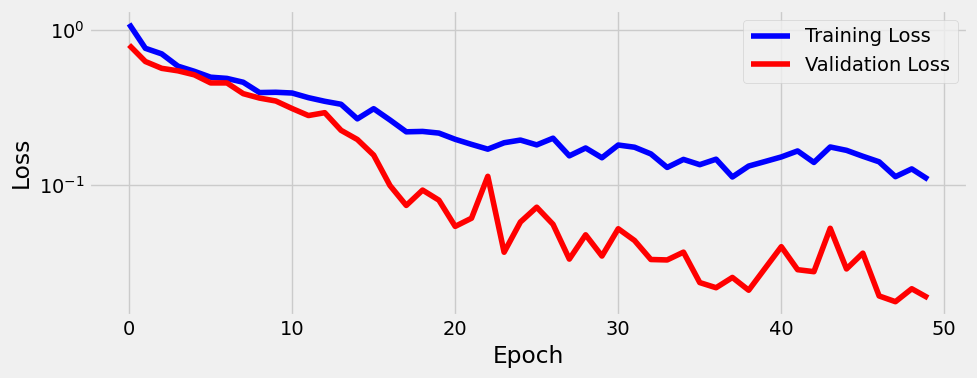

In [38]:
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(10, 4))
plt.plot(train_losses, label="Training Loss", c="b")
plt.plot(val_losses, label="Validation Loss", c="r")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.tight_layout()

In [39]:
# training loss:
torch.manual_seed(11)
x, t = next(iter(train_loader))
x, t = x.to(device), t.to(device)
model.train()
y = model(x)  # using forward
loss = loss_fn(y, t)
loss

tensor(0.0856, device='mps:0', grad_fn=<MseLossBackward0>)

In [40]:
# test loss:
model.eval()
y = model(x)  # using predict
test_loss = loss_fn(y, t)
test_loss

tensor(0.0151, device='mps:0')